In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from datetime import datetime
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
torch.cuda.manual_seed_all(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Processing

In [16]:

train_csv = 'train'
# train_csv = 'corrected_train'

train_df = pd.read_csv(f'{train_csv}.csv')

train_df['image_path'] = train_df['image_id'].apply(
    lambda x: f'images/train/{x}.jpg')
print("Training Data:")
print(train_df.head())

class PlantDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        labels = self.dataframe.iloc[idx][[
            'healthy', 'multiple_diseases', 'rust', 'scab']].values.astype('float32')
        if self.transform:
            image = self.transform(image)
        return image, labels


# 定义训练和验证图像的变换
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.1)
    ], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 划分训练和验证数据集
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[[
                                        'healthy', 'multiple_diseases', 'rust', 'scab']])

# 创建数据集和数据加载器
train_dataset = PlantDataset(train_data, transform=train_transform)
val_dataset = PlantDataset(val_data, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 显示数据集的一些基本信息
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Training Data:
  image_id  healthy  multiple_diseases  rust  scab                image_path
0  Train_0        0                  0     0     1  images/train/Train_0.jpg
1  Train_1        0                  1     0     0  images/train/Train_1.jpg
2  Train_2        1                  0     0     0  images/train/Train_2.jpg
3  Train_3        0                  0     1     0  images/train/Train_3.jpg
4  Train_4        1                  0     0     0  images/train/Train_4.jpg
Number of training samples: 1456
Number of validation samples: 365


### Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


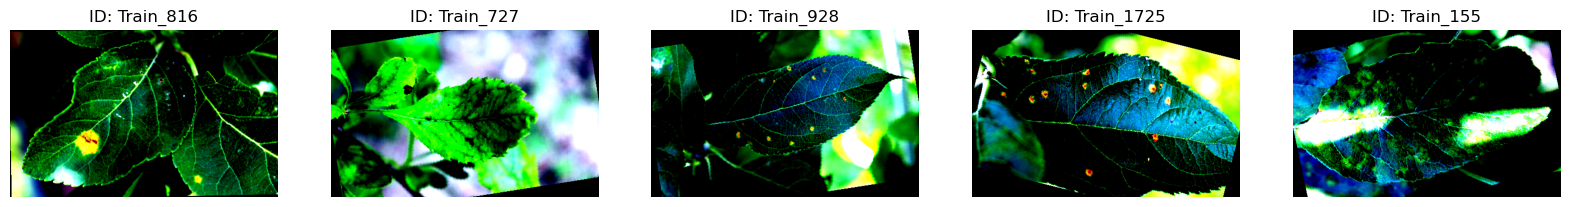

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image, labels = train_dataset[i]
    img_id = train_data.iloc[i]['image_id']
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(f'ID: {img_id}')
    ax.axis('off')
plt.show()

## Model Training

In [18]:
def get_model_name(model):
    full_type_name = str(type(model))
    last_part = full_type_name.split('.')[-1].strip("'>")
    return last_part

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=5):
    scaler = GradScaler()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    log_dir = os.path.join("runs", f"{get_model_name(model)}_{timestamp}")
    model_dir = 'model'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    writer = SummaryWriter(log_dir)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        n = len(train_loader.dataset)
        model.train()
        running_loss = 0.0
        running_corrects = 0
        pbar = tqdm(train_loader)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == torch.max(labels, 1)[1])
            pbar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / n
        epoch_acc = running_corrects / n

        val_loss, val_acc = validate_model(model, val_loader, loss_fn)
        print(f"""Epoch {epoch+1}/{num_epochs}  
            Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}
            Valid Loss: {val_loss:.4f} Acc: {val_acc:.4f}""")
        
        # TensorBoard 每个 epoch 记录一次
        writer.add_scalars('Loss', {'train': epoch_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': epoch_acc, 'val': val_acc}, epoch)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model, f'./model/{train_csv}_{get_model_name(model)}_acc{best_acc:.3f}.pth')
    writer.close()
    return model


def validate_model(model, val_loader, loss_fn):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    n=len(val_loader.dataset)
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model(inputs)
            loss = loss_fn(outputs, torch.max(labels, 1)[1])

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == torch.max(labels, 1)[1])

    val_loss = running_loss / n
    val_acc = running_corrects / n

    return val_loss, val_acc

In [9]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, 4)

    def forward(self, x):
        return self.model(x)

In [ ]:
torch.cuda.empty_cache()
model = ResNet18().to(device)
loss_fn = nn.CrossEntropyLoss().cuda(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Train the model
num_epochs = 5
trained_model = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, num_epochs=num_epochs)

In [10]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(
            self.model.classifier[1].in_features, 4)

    def forward(self, x):
        return self.model(x)


In [ ]:
torch.cuda.empty_cache()
model = EfficientNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# EfficientNet
num_epochs = 5
trained_model = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

## Evaluation

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, 4)
    def forward(self, x):
        return self.model(x)
    
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(
            self.model.classifier[1].in_features, 4)
    def forward(self, x):
        return self.model(x)

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

best_model_path = './model/train_ResNet18_acc0.940.pth'
best_model = torch.load(best_model_path)

# 获取预测值和实际值
val_preds, val_labels = evaluate_model(best_model, val_loader)


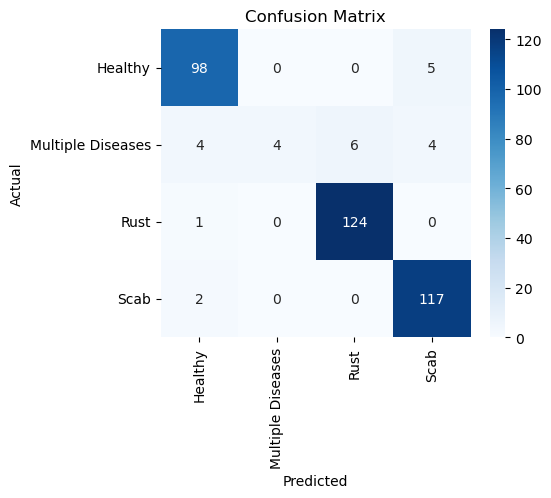

                   precision    recall  f1-score   support

          Healthy       0.93      0.95      0.94       103
Multiple Diseases       1.00      0.22      0.36        18
             Rust       0.95      0.99      0.97       125
             Scab       0.93      0.98      0.96       119

         accuracy                           0.94       365
        macro avg       0.95      0.79      0.81       365
     weighted avg       0.94      0.94      0.93       365

Validation Accuracy: 0.9397


In [51]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(val_labels, val_preds)

# 绘制混淆矩阵
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'], yticklabels=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(val_labels, val_preds, target_names=['Healthy', 'Multiple Diseases', 'Rust', 'Scab']))

# 计算准确率
accuracy = accuracy_score(val_labels, val_preds)
print(f'Validation Accuracy: {accuracy:.4f}')


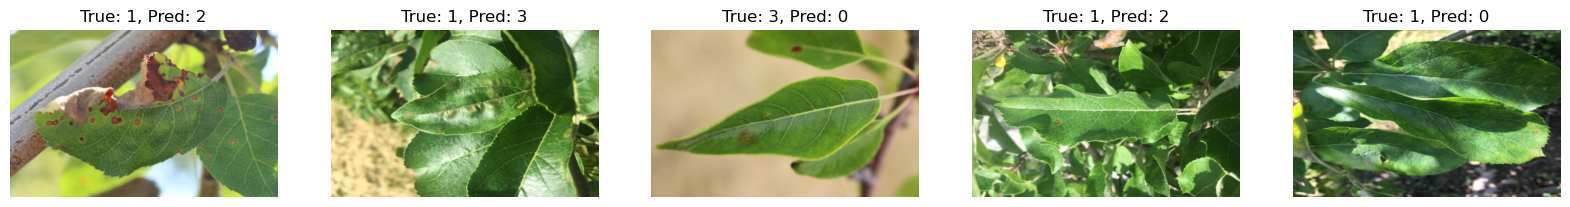

In [9]:
def visualize_misclassified_samples(model, val_loader, num_samples=5):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            misclassified_mask = preds != torch.max(labels, 1)[1]
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            misclassified_labels.extend(torch.max(labels[misclassified_mask], 1)[1].cpu().numpy())
            misclassified_preds.extend(preds[misclassified_mask].cpu().numpy())
            if len(misclassified_images) >= num_samples:
                break

    misclassified_images = misclassified_images[:num_samples]
    misclassified_labels = misclassified_labels[:num_samples]
    misclassified_preds = misclassified_preds[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        image = misclassified_images[i].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f'True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}')
        ax.axis('off')
    plt.show()

# 可视化错误预测的样本
visualize_misclassified_samples(best_model, val_loader, num_samples=5)


## Imbalanced Data Probelm

C:\Users\lurkerlin\AppData\Local\Temp\ipykernel_2212\456528981.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


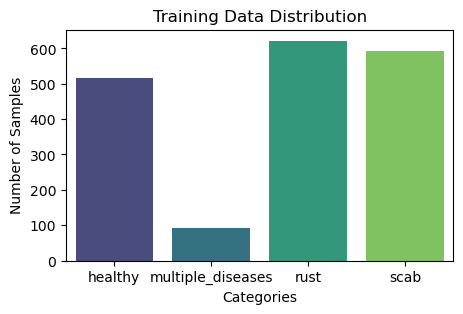

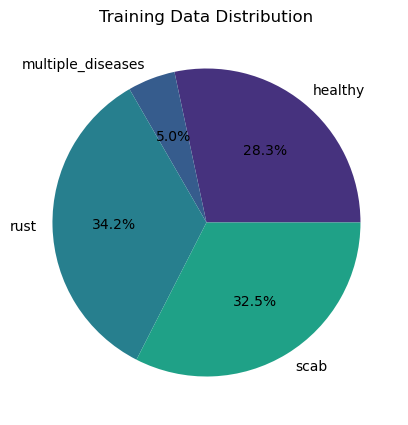

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每个类别的样本数量
category_counts = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()

# 绘制条形图
plt.figure(figsize=(5, 3))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Training Data Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Samples')
plt.show()

# 绘制饼图
plt.figure(figsize=(5, 5))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Training Data Distribution')
plt.show()


### Oversample

In [19]:
# 重新采样（过采样少数类）
from sklearn.utils import resample


healthy = train_df[train_df.healthy == 1]
multiple_diseases = train_df[train_df.multiple_diseases == 1]
rust = train_df[train_df.rust == 1]
scab = train_df[train_df.scab == 1]

# 过采样少数类
multiple_diseases_upsampled = resample(multiple_diseases,
                                       replace=True,  # 允许放回
                                       n_samples=len(rust),  # 设定过采样后的样本数
                                       random_state=42)  # 固定随机种子

# 组合过采样后的数据集
train_df_balanced = pd.concat([healthy, multiple_diseases_upsampled, rust, scab])

# 打乱数据
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 重新定义数据集和数据加载器
train_dataset_balanced = PlantDataset(train_df_balanced, transform=train_transform)
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=64, shuffle=True)




multiple_diseases
0    1730
1     622
Name: count, dtype: int64


C:\Users\lurkerlin\AppData\Local\Temp\ipykernel_2212\3926730315.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


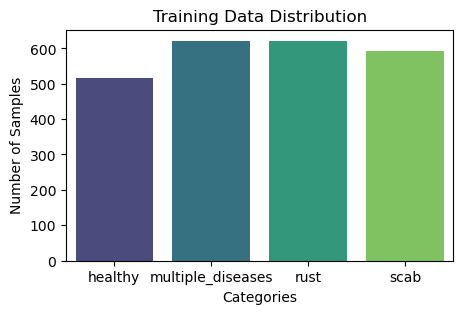

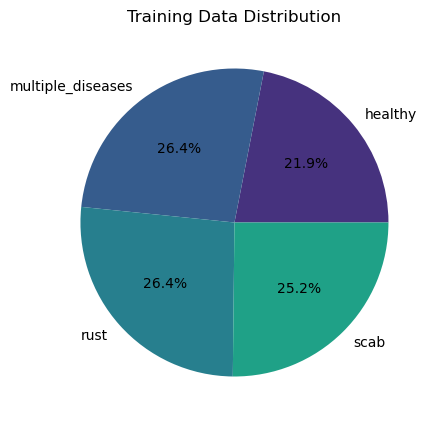

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 统计每个类别的样本数量
category_counts = train_df_balanced[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()

# 绘制条形图
plt.figure(figsize=(5, 3))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Training Data Distribution')
plt.xlabel('Categories')
plt.ylabel('Number of Samples')
plt.show()

# 绘制饼图
plt.figure(figsize=(5, 5))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Training Data Distribution')
plt.show()



In [22]:
# 重新训练ResNet18
torch.cuda.empty_cache()
model_resnet = ResNet18().to(device)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)
num_epochs = 5

# 训练模型
trained_model_resnet = train_model(
    model_resnet, train_loader_balanced, val_loader, loss_fn, optimizer_resnet, num_epochs=num_epochs)


# 重新训练EfficientNet
torch.cuda.empty_cache()
model_efficientnet = EfficientNet().to(device)
optimizer_efficientnet = optim.Adam(model_efficientnet.parameters(), lr=0.001)
num_epochs = 5

# 训练模型
trained_model_efficientnet = train_model(
    model_efficientnet, train_loader_balanced, val_loader, loss_fn_weighted, optimizer_efficientnet, num_epochs)


100%|██████████| 37/37 [01:52<00:00,  3.03s/it, loss=0.0851]


Epoch 1/5  
            Train Loss: 0.1393 Acc: 0.7738
            Valid Loss: 0.8948 Acc: 0.7260


100%|██████████| 37/37 [01:49<00:00,  2.97s/it, loss=0.053] 


Epoch 2/5  
            Train Loss: 0.0694 Acc: 0.8984
            Valid Loss: 0.1175 Acc: 0.9534


100%|██████████| 37/37 [01:54<00:00,  3.10s/it, loss=0.0248]


Epoch 3/5  
            Train Loss: 0.0573 Acc: 0.9184
            Valid Loss: 0.1765 Acc: 0.9315


100%|██████████| 37/37 [01:53<00:00,  3.08s/it, loss=0.143] 


Epoch 4/5  
            Train Loss: 0.0511 Acc: 0.9247
            Valid Loss: 0.4845 Acc: 0.7836


100%|██████████| 37/37 [01:54<00:00,  3.08s/it, loss=0.0197]


Epoch 5/5  
            Train Loss: 0.0482 Acc: 0.9345
            Valid Loss: 0.0794 Acc: 0.9726


100%|██████████| 37/37 [05:34<00:00,  9.03s/it, loss=0.0324]


Epoch 1/5  
            Train Loss: 0.1167 Acc: 0.8299
            Valid Loss: 0.1208 Acc: 0.9589


100%|██████████| 37/37 [03:55<00:00,  6.36s/it, loss=0.0445]


Epoch 2/5  
            Train Loss: 0.0406 Acc: 0.9388
            Valid Loss: 0.0428 Acc: 0.9890


100%|██████████| 37/37 [14:02<00:00, 22.77s/it, loss=0.0105] 


Epoch 3/5  
            Train Loss: 0.0341 Acc: 0.9537
            Valid Loss: 0.0756 Acc: 0.9808


100%|██████████| 37/37 [03:33<00:00,  5.78s/it, loss=0.0041] 


Epoch 4/5  
            Train Loss: 0.0302 Acc: 0.9613
            Valid Loss: 0.1281 Acc: 0.9507


100%|██████████| 37/37 [03:22<00:00,  5.47s/it, loss=0.00931]


Epoch 5/5  
            Train Loss: 0.0178 Acc: 0.9741
            Valid Loss: 0.0398 Acc: 0.9918


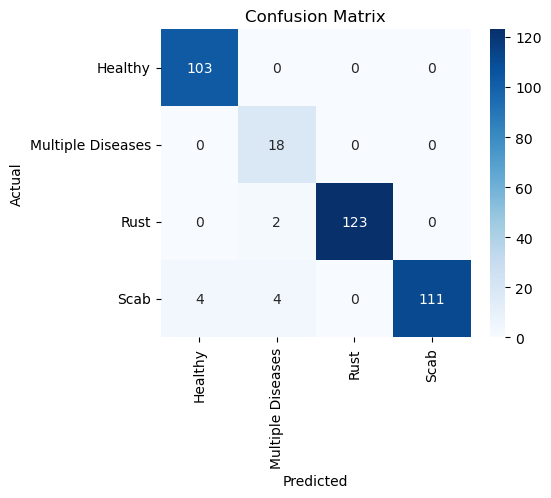

                   precision    recall  f1-score   support

          Healthy       0.96      1.00      0.98       103
Multiple Diseases       0.75      1.00      0.86        18
             Rust       1.00      0.98      0.99       125
             Scab       1.00      0.93      0.97       119

         accuracy                           0.97       365
        macro avg       0.93      0.98      0.95       365
     weighted avg       0.98      0.97      0.97       365

Validation Accuracy: 0.9726


In [52]:

best_model_path = './model/train_ResNet18_acc0.973.pth'
best_model = torch.load(best_model_path)

# 获取预测值和实际值
val_preds, val_labels = evaluate_model(best_model, val_loader)
# 计算混淆矩阵
conf_matrix = confusion_matrix(val_labels, val_preds)

# 绘制混淆矩阵
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'], yticklabels=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(val_labels, val_preds, target_names=['Healthy', 'Multiple Diseases', 'Rust', 'Scab']))

# 计算准确率
accuracy = accuracy_score(val_labels, val_preds)
print(f'Validation Accuracy: {accuracy:.4f}')


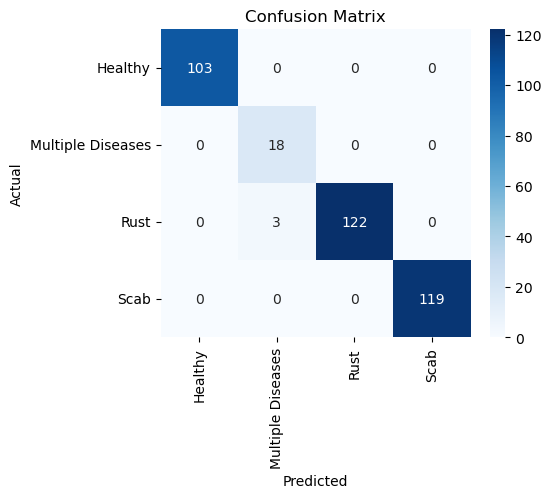

                   precision    recall  f1-score   support

          Healthy       1.00      1.00      1.00       103
Multiple Diseases       0.86      1.00      0.92        18
             Rust       1.00      0.98      0.99       125
             Scab       1.00      1.00      1.00       119

         accuracy                           0.99       365
        macro avg       0.96      0.99      0.98       365
     weighted avg       0.99      0.99      0.99       365

Validation Accuracy: 0.9918


In [54]:

best_model_path = './model/train_EfficientNet_acc0.992.pth'
best_model = torch.load(best_model_path)

# 获取预测值和实际值
val_preds, val_labels = evaluate_model(best_model, val_loader)
# 计算混淆矩阵
conf_matrix = confusion_matrix(val_labels, val_preds)

# 绘制混淆矩阵
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'], yticklabels=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(val_labels, val_preds, target_names=['Healthy', 'Multiple Diseases', 'Rust', 'Scab']))

# 计算准确率
accuracy = accuracy_score(val_labels, val_preds)
print(f'Validation Accuracy: {accuracy:.4f}')

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 计算预测概率
def predict_probabilities(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

# 获取验证集上的预测概率和实际标签
val_probs, val_labels = predict_probabilities(trained_model_efficientnet, val_loader)

# 将标签二值化
val_labels_binarized = label_binarize(val_labels, classes=[0, 1, 2, 3])

# 计算每个类别的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = val_labels_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


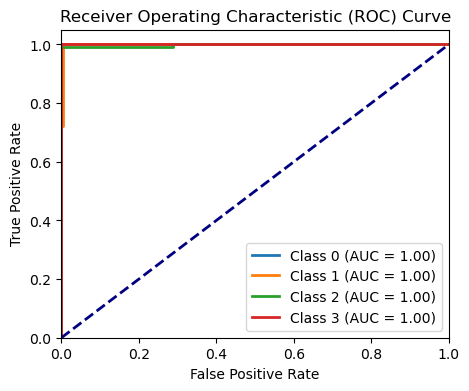

In [27]:
# 绘制所有类别的ROC曲线
plt.figure(figsize=(5, 4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Submission

In [24]:
# 读取测试数据集的CSV文件
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.dataframe.iloc[idx]['image_id']


test_df = pd.read_csv('test.csv')
test_df['image_path'] = test_df['image_id'].apply(
    lambda x: f'images/test/{x}.jpg')

# 创建测试数据集和数据加载器
test_dataset = TestDataset(test_df, transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# best_model_path = './model/train_EfficientNet_acc0.992.pth'
best_model_path = './model/train_ResNet18_acc0.973.pth'

best_model = torch.load(best_model_path)
best_model.eval()


def inference(model, test_loader):
    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for inputs, ids in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probs)
            image_ids.extend(ids)
    return np.array(predictions), image_ids


# 在测试集上进行推理
test_predictions, test_image_ids = inference(best_model, test_loader)

# 创建提交文件
submission = pd.DataFrame(test_predictions, columns=[
                          'healthy', 'multiple_diseases', 'rust', 'scab'])
submission['image_id'] = test_image_ids
submission = submission[['image_id', 'healthy',
                         'multiple_diseases', 'rust', 'scab']]
submission_dir = 'submissions'
if not os.path.exists(submission_dir):
    os.makedirs(submission_dir)
submission.to_csv(f'./submissions/{get_model_name(best_model)}_{train_csv}_submission.csv', index=False)

print(f"推理完成，提交文件已保存为 {get_model_name(best_model)}_{train_csv}_submission.csv")

推理完成，提交文件已保存为 EfficientNet_train_submission.csv
